In [1]:
import os
from PIL import Image, ImageDraw
import mmcv, cv2
import time
import sys
import matplotlib.pyplot as plt
from IPython import display
import torchvision.transforms as transforms
import numpy as np
from numpy import dot
from numpy.linalg import norm
import torch

from facenet_pytorch import MTCNN, InceptionResnetV1

In [2]:
# Upsampling via SR
device = torch.device('cuda')
model_path = 'SRGAN_FaceLoss_x4_epoch_28.pth'
model = torch.load(model_path, map_location=lambda storage, loc: storage.cuda(0)).to(device)

def super_resolve(img):
    upsample = img.convert('RGB').resize((56,56),resample=Image.BICUBIC)
    data = (transforms.ToTensor()(upsample)).view(1, 3, upsample.size[1], upsample.size[0])
    data = data.to(device)
    out = model(data)
    out = out.cpu()
    out_img = out.data[0].numpy()
    out_img *= 255.0
    out_img = out_img.clip(0, 255)
    out_img = out_img.transpose((1,2,0))
    out_img = Image.fromarray(np.uint8(out_img), mode='RGB')
    out_img = out_img.resize((160,160), Image.BICUBIC)
    return out_img

def cos_sim(a,b):
    return 1 - dot(a, b)/(norm(a)*norm(b))

/home/angelo/Desktop/Github/virtual_envs/image_app/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'GAN_model.Generator' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [3]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()

def return_embedding(img):
    img_as_tensor = transforms.ToTensor()(img)
    img_emb = resnet(img_as_tensor.unsqueeze(0)).squeeze(0).detach().numpy()
    return img_emb

In [4]:
path = '../video/fitdance.mp4'
face_detector = MTCNN(keep_all=True)

video = mmcv.VideoReader(path)
#frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]
#display.Video('video.mp4', width=640)

In [5]:
frames_used = int(video.frame_cnt/video.fps)
frames = []
counter = 0 
for _ in range(frames_used):
    frames.append(Image.fromarray(cv2.cvtColor(video[counter], cv2.COLOR_BGR2RGB)))
    counter += int(video.fps)

In [6]:
# Probe images

frames_tracked = []
face_embeddings = []
face_list = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = face_detector.detect(frame)
    
    # Draw faces
    #frame_draw = frame.copy()
    #draw = ImageDraw.Draw(frame_draw)
    
    isEmpty = (str(type(boxes)) == "<class 'NoneType'>")
    
    if not isEmpty: 
        for box in boxes:
            cropped_face = frame.crop(box.tolist()).resize((160,160), resample=Image.BICUBIC) # Bicubic
            #cropped_face = super_resolve(frame.crop(box.tolist())) # SRGAN
            
            face_embeddings.append(return_embedding(cropped_face))
            face_list.append(frame.crop(box.tolist()))
            #draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
        
    # Add to frame list
    #frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 158
Done


In [33]:
# Gallery image and embedding

gallery_image = Image.open('../gallery/tay.jpeg')
box, _ = face_detector.detect(gallery_image)
cropped_face = gallery_image.crop(box[0].tolist()).resize((160,160), resample=Image.BICUBIC)
#cropped_face = super_resolve(gallery_image.crop(box[0].tolist())) # SRGAN
gallery_embedding = return_embedding(cropped_face)

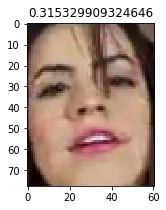

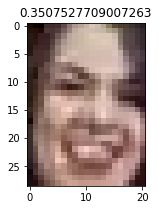

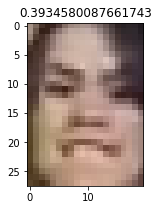

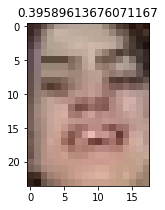

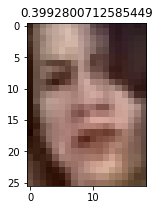

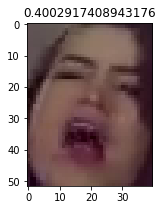

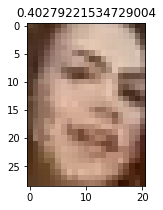

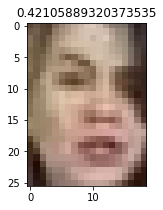

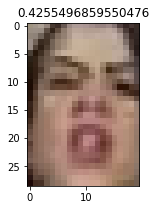

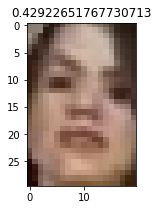

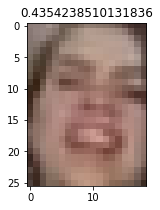

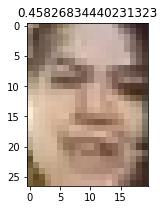

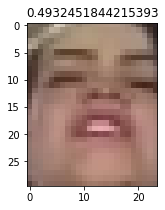

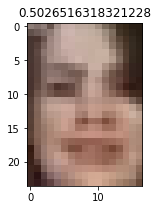

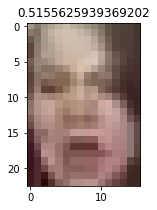

In [34]:
similarities = []

for probe_embedding in face_embeddings:
    similarities.append(cos_sim(gallery_embedding, probe_embedding))

# Last 15
best = np.array(similarities).argsort()[:15]

for index in best:
    plt.figure(figsize=(3,3))
    plt.title(similarities[index])
    plt.imshow(face_list[index])

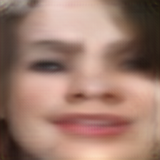

In [47]:
super_resolve(face_list[best[-2]])

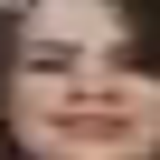

In [48]:
face_list[best[-2]].resize((160,160), resample=Image.BICUBIC)

In [ ]:
'''d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass'''

In [ ]:
'''dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()'''